In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [15]:
# 1. Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
# 2. Data cleaning
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [17]:
# 3. Feature engineering
df['AvgMonthlyCharge'] = df['TotalCharges'] / (df['tenure'] + 1)
df['IsSeniorWithPartner'] = ((df['SeniorCitizen'] == 1) & (df['Partner'] == 'Yes')).astype(int)
df['TotalServices'] = df[
    ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
     'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
].apply(lambda row: sum(row == 'Yes'), axis=1)
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])
df['IsEngaged'] = ((df['OnlineSecurity'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)
df['ChargesPerService'] = df['TotalCharges'] / (df['TotalServices'] + 1)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlyCharge,IsSeniorWithPartner,TotalServices,TenureGroup,IsEngaged,ChargesPerService
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Electronic check,29.85,29.85,0,14.925000,0,1,0-12,0,14.9250
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,Mailed check,56.95,1889.50,0,53.985714,0,3,25-48,1,472.3750
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Mailed check,53.85,108.15,1,36.050000,0,3,0-12,1,27.0375
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Bank transfer (automatic),42.30,1840.75,0,40.016304,0,3,25-48,1,460.1875
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Electronic check,70.70,151.65,1,50.550000,0,1,0-12,0,75.8250


In [6]:
# 4. Encode categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(df.drop(columns=['Churn']), columns=categorical_cols, drop_first=True)
y = df['Churn']

In [7]:
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [9]:
# 7. Build pipeline: StandardScaler + SMOTE + CatBoost
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('catboost', CatBoostClassifier(
        eval_metric='AUC',
        random_seed=42,
        verbose=0
    ))
])

In [10]:
# 8. Grid search parameter space
param_grid = {
    'catboost__iterations': [300, 500],
    'catboost__learning_rate': [0.03, 0.05],
    'catboost__depth': [6, 8],
    'catboost__class_weights': [[1, 2], [1, 2.5], [1, 3]]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x000001F7F8D33390>)]),
             n_jobs=-1,
             param_grid={'catboost__class_weights': [[1, 2], [1, 2.5], [1, 3]],
                         'catboost__depth': [6, 8],
                         'catboost__iterations': [300, 500],
                         'catboost__learning_rate': [0.03, 0.05]},
             scoring='roc_auc', verbose=1)

In [11]:
# 9. Best model and parameters
print("\n✅ Best Parameters:", grid.best_params_)
print(f"✅ Best CV AUC: {grid.best_score_:.4f}")


✅ Best Parameters: {'catboost__class_weights': [1, 2], 'catboost__depth': 6, 'catboost__iterations': 300, 'catboost__learning_rate': 0.03}
✅ Best CV AUC: 0.8450


In [12]:
# 10. Test predictions
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

In [13]:
# 11. Evaluation
print("\n📊 Test Set Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


📊 Test Set Performance:
Accuracy:  0.7473
Precision: 0.5153
Recall:    0.8128
F1 Score:  0.6307
ROC AUC:   0.8422

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.52      0.81      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

Confusion Matrix:
 [[749 286]
 [ 70 304]]


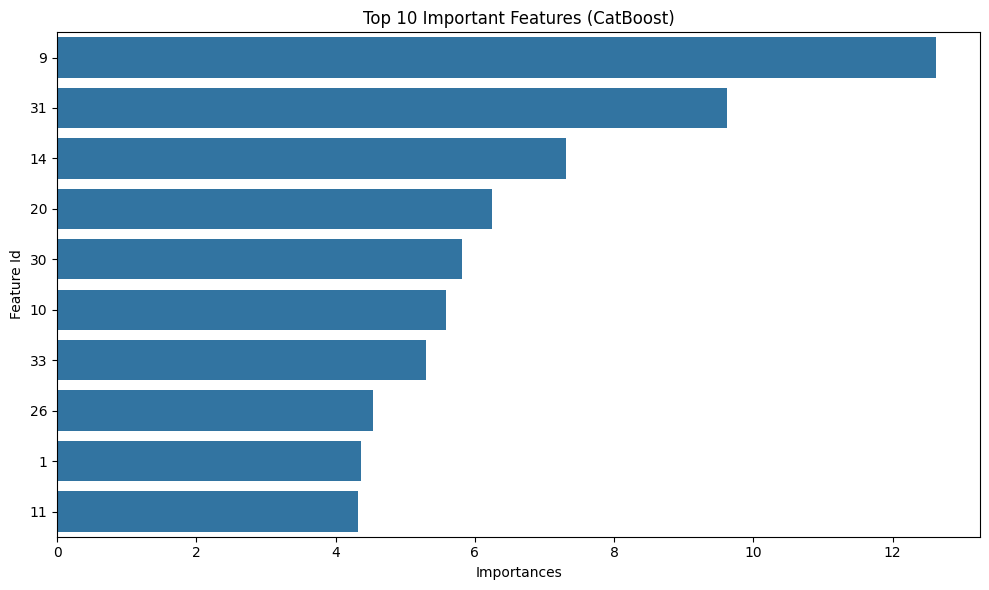

In [14]:
# 12. Feature Importance
model_final = grid.best_estimator_.named_steps['catboost']
feat_imp = model_final.get_feature_importance(prettified=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=feat_imp.head(10))
plt.title("Top 10 Important Features (CatBoost)")
plt.tight_layout()
plt.show()